### Precision Segmentation of Retinal Nerve Fibers in Fundus Images using Deep Learning


Extracting the zip files containg datasets

In [ ]:
import zipfile

# Extract the contents of the first ZIP file
with zipfile.ZipFile('/content/rpi_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_data')

# Extract the contents of the second ZIP file
with zipfile.ZipFile('/content/all_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_data')


### Image and Mask Preprocessing from Multiple Datasets
This code snippet is tailored to efficiently load and preprocess image data along with corresponding masks from multiple specified directories. It utilizes TensorFlow's image handling capabilities to resize, normalize, and prepare images for uniform input into machine learning models, while also binarizing masks for tasks such as segmentation. The script ensures that images and masks are aligned by name and then splits the data into training and validation sets, which helps in optimizing model training and evaluation processes. This approach allows for the integration of varied datasets, enhancing the robustness and generalizability of the trained models.

In [ ]:
import os
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.model_selection import train_test_split

# Function to gather file paths based on categories and file extensions
def collect_file_paths(base_directory, categories_list):
    file_paths = {}
    for category in categories_list:
        extension = "*.tif" if "mask" in category.lower() else "*.jpg"
        file_paths[category] = sorted(glob.glob(f"{base_directory}/{category}/" + extension))
    return file_paths

# Function to process and load images, including preprocessing for masks
def process_image(filepath, is_binary_mask=False, size=(256, 256)):
    image = load_img(filepath, target_size=size, color_mode='grayscale' if is_binary_mask else 'rgb')
    image_array = img_to_array(image)
    if is_binary_mask:
        image_array = (image_array > 127).astype(np.float32)
    else:
        image_array = image_array.astype(np.float32) / 255.0
    return image_array.squeeze(-1) if is_binary_mask else image_array

# Define dataset directory and categories
dataset_directory = "/content/sample_data"
categories = ["images", "masks"]

# Collect paths for images and masks
file_paths = collect_file_paths(dataset_directory, categories)

# Find common file names between images and masks for pairing
image_filenames = set(os.path.splitext(os.path.basename(path))[0] for path in file_paths['images'])
mask_filenames = set(os.path.splitext(os.path.basename(path))[0] for path in file_paths['masks'])

common_filenames = image_filenames & mask_filenames
paired_image_paths = [path for path in file_paths['images'] if os.path.splitext(os.path.basename(path))[0] in common_filenames]
paired_mask_paths = [path for path in file_paths['masks'] if os.path.splitext(os.path.basename(path))[0] in common_filenames]

# Load paired images and masks into memory
images = [process_image(path) for path in paired_image_paths]
masks = [process_image(path, is_binary_mask=True) for path in paired_mask_paths]

# Convert lists to numpy arrays
images_array = np.array(images)
masks_array = np.array(masks)

# Split data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images_array, masks_array, test_size=0.2, random_state=42)

# Display dataset sizes for verification
print(f"Training dataset shapes: Images {train_images.shape}, Masks {train_masks.shape}")
print(f"Validation dataset shapes: Images {val_images.shape}, Masks {val_masks.shape}")

# Normalize mask values
train_masks_normalized = train_masks / 255.0
val_masks_normalized = val_masks / 255.0


Training set shapes: Images (24, 256, 256, 3), Masks (24, 256, 256)
Validation set shapes: Images (6, 256, 256, 3), Masks (6, 256, 256)


### Visualizing Image and Mask Pairs
This script is designed to display pairs of images alongside their corresponding masks, providing a visual verification of the data preprocessing and alignment. It randomly selects three examples from the datasets and presents each image with its respective mask in a side-by-side format.

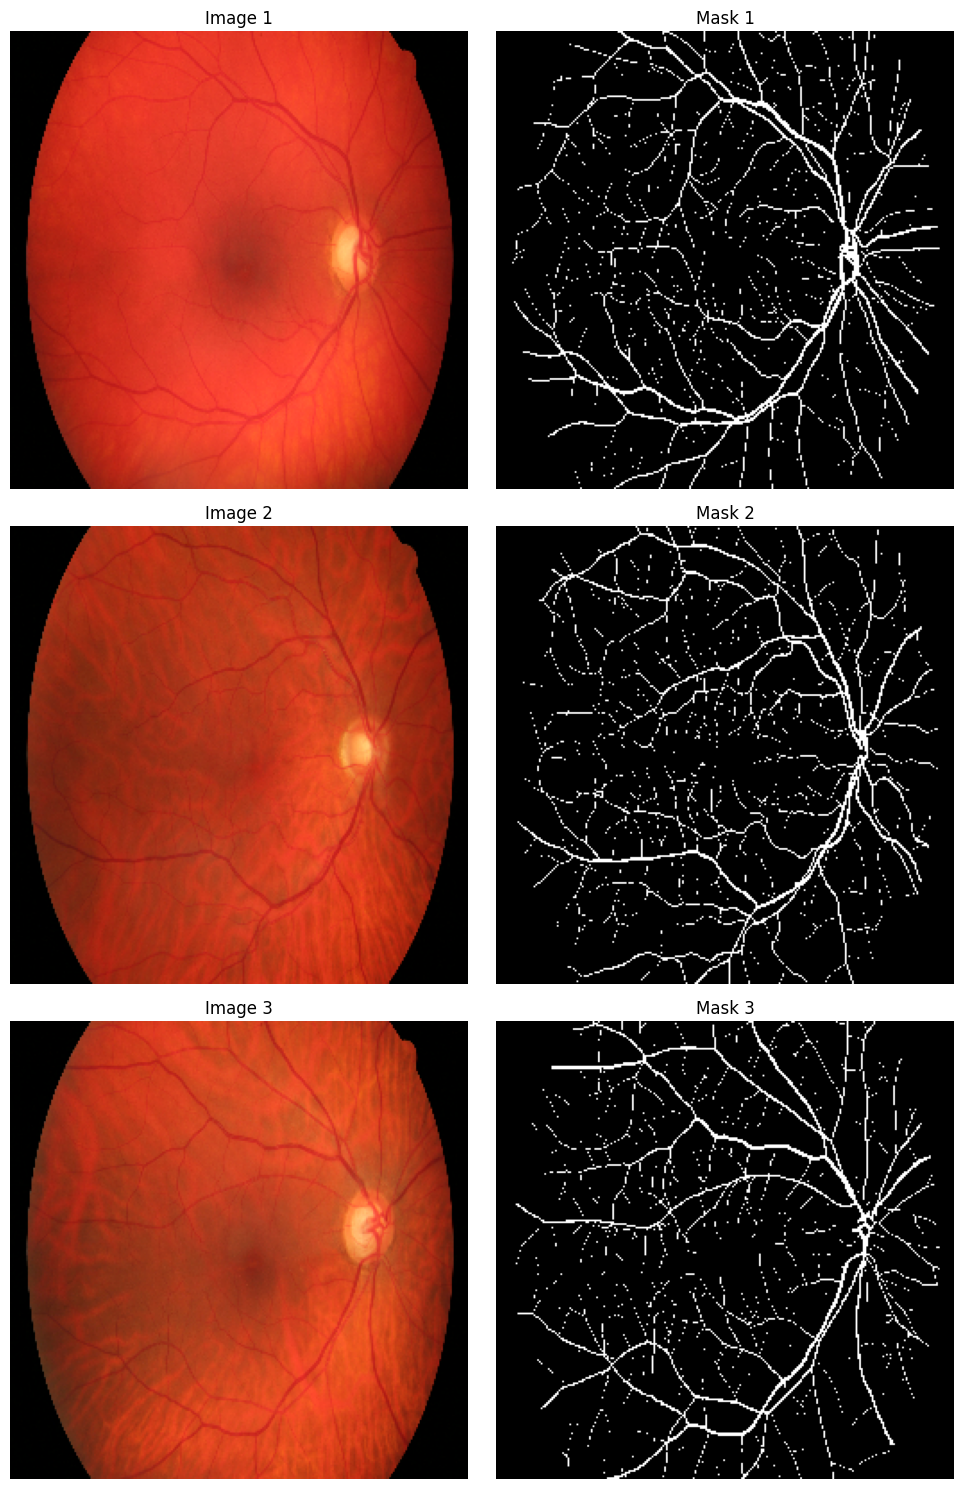

In [ ]:
import matplotlib.pyplot as plt

def visualize_images_and_masks(image_set, mask_set, samples_to_display=3):
    """
    Display images alongside their corresponding masks.

    Parameters:
        image_set (numpy.ndarray): Array of images to display.
        mask_set (numpy.ndarray): Array of masks corresponding to the images.
        samples_to_display (int): Number of image-mask pairs to display.
    """
    plt.figure(figsize=(12, 5 * samples_to_display))  # Adjust figure size based on the number of samples

    for index in range(samples_to_display):
        # Display the image
        plt.subplot(samples_to_display, 2, 2 * index + 1)
        plt.imshow(image_set[index], cmap='viridis')  # Use a different colormap for better visualization
        plt.title(f'Image {index + 1}')
        plt.axis('off')

        # Display the corresponding mask
        plt.subplot(samples_to_display, 2, 2 * index + 2)
        plt.imshow(mask_set[index], cmap='gray')  # Keep masks in grayscale
        plt.title(f'Mask {index + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Select samples from the training dataset to visualize
sample_images_to_display = train_images[:3]
sample_masks_to_display = train_masks_normalized[:3]

# Call the function to display images and masks
visualize_images_and_masks(sample_images_to_display, sample_masks_to_display)


### EfficientNetB0-Based U-Net Model Setup
This configuration establishes a U-Net model leveraging the EfficientNetB0 architecture as its backbone, specifically designed for binary classification tasks. The model harnesses pretrained ImageNet weights to maximize initial feature extraction effectiveness. Setup within the TensorFlow Keras environment under the segmentation models framework ensures smooth integration and optimal performance. The model is prepared with Adam optimizer and binary cross-entropy loss, which is ideal for dichotomous outcome predictions. This setup is primed for training with appropriately formatted and dimensioned datasets.

In [ ]:
import os
import tensorflow as tf
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt

# Configure TensorFlow Keras backend for segmentation_models
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')

# Define model parameters
BACKBONE = 'efficientnetb0'
NUM_CLASSES = 1
OUTPUT_ACTIVATION = 'sigmoid'

# Build and compile the U-Net model with EfficientNetB0 as the backbone
unet_model = sm.Unet(
    BACKBONE,
    classes=NUM_CLASSES,
    activation=OUTPUT_ACTIVATION,
    encoder_weights='imagenet'
)
unet_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Specify path and save the model
model_save_path = '/mnt/data/unet_segmentation_model.h5'
unet_model.save(model_save_path)
print(f"Model successfully saved at {model_save_path}")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at /mnt/data/segmentation_model.h5


### Training the EfficientNetB0 Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path and configure the ModelCheckpoint callback
save_path_template = '/mnt/data/segmentation_model_epoch_{epoch:02d}.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=save_path_template,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the model and include the checkpoint callback
training_history = unet_model.fit(
    x=X_train,
    y=y_train_normalized,
    batch_size=5,
    epochs=500,
    validation_split=0.2,
    verbose=2,
    callbacks=[checkpoint_callback]
)


Epoch 1/500

Epoch 1: val_loss improved from inf to 8.21206, saving model to /mnt/data/segmentation_model_epoch_01.h5
4/4 - 38s - loss: 1.1347 - accuracy: 0.0897 - val_loss: 8.2121 - val_accuracy: 0.0038 - 38s/epoch - 9s/step
Epoch 2/500

Epoch 2: val_loss did not improve from 8.21206
4/4 - 0s - loss: 0.8267 - accuracy: 0.2143 - val_loss: 13.5111 - val_accuracy: 0.0037 - 264ms/epoch - 66ms/step
Epoch 3/500

Epoch 3: val_loss did not improve from 8.21206
4/4 - 0s - loss: 0.6581 - accuracy: 0.5146 - val_loss: 14.1264 - val_accuracy: 0.0305 - 276ms/epoch - 69ms/step
Epoch 4/500

Epoch 4: val_loss did not improve from 8.21206
4/4 - 0s - loss: 0.5480 - accuracy: 0.8289 - val_loss: 12.8004 - val_accuracy: 0.0846 - 263ms/epoch - 66ms/step
Epoch 5/500

Epoch 5: val_loss did not improve from 8.21206
4/4 - 0s - loss: 0.4708 - accuracy: 0.9020 - val_loss: 10.1133 - val_accuracy: 0.1515 - 265ms/epoch - 66ms/step
Epoch 6/500

Epoch 6: val_loss improved from 8.21206 to 2.29508, saving model to /mnt/

### Visualizing Model Training Progress


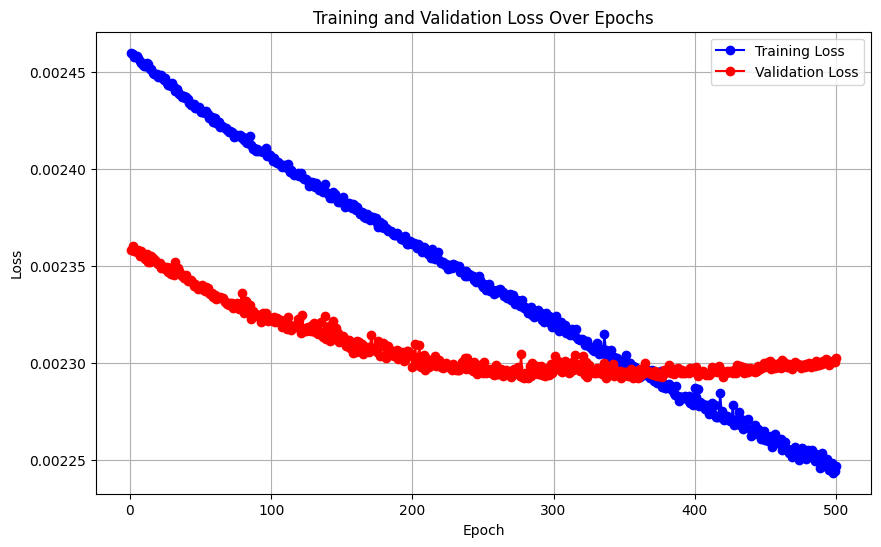

In [ ]:
import matplotlib.pyplot as plt

# Extract the loss history from the model training process
train_loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

# Define the range of epochs for the x-axis
epoch_range = range(1, len(train_loss) + 1)

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_range, train_loss, 'b-', marker='o', label='Training Loss')
plt.plot(epoch_range, val_loss, 'r-', marker='o', label='Validation Loss')
plt.title('Loss During Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Displaying Image Segmentation Results
This function visualizes the results of image segmentation by displaying the original image, its true mask, and the predicted mask side-by-side. Each validation image is processed to predict its mask using the trained model, and the results are plotted in a row for easy comparison:

1/1 [==============================] - 2s 2s/step


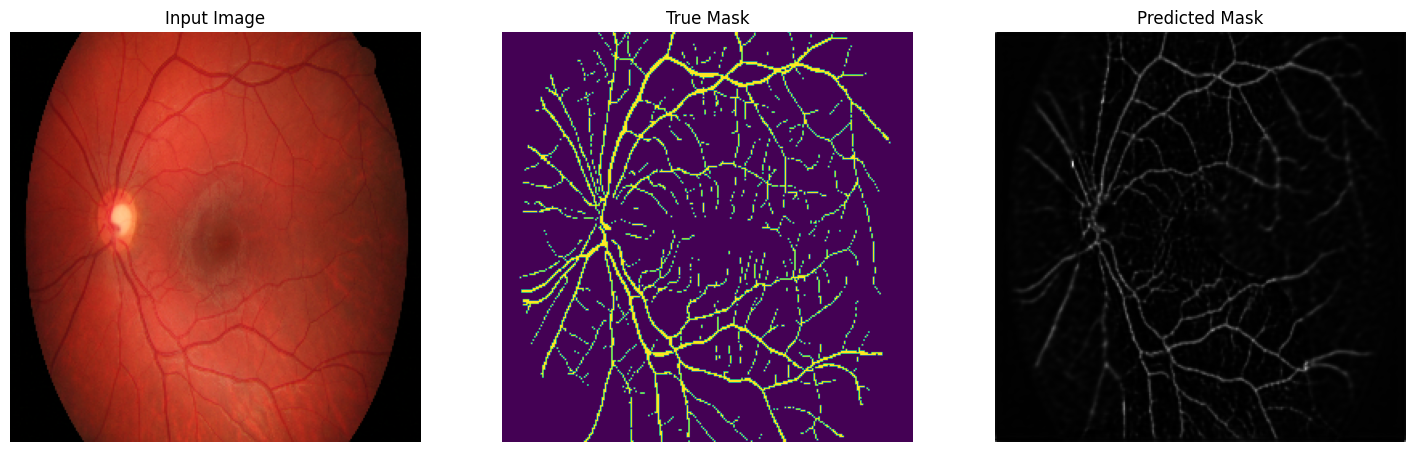

1/1 [==============================] - 0s 46ms/step


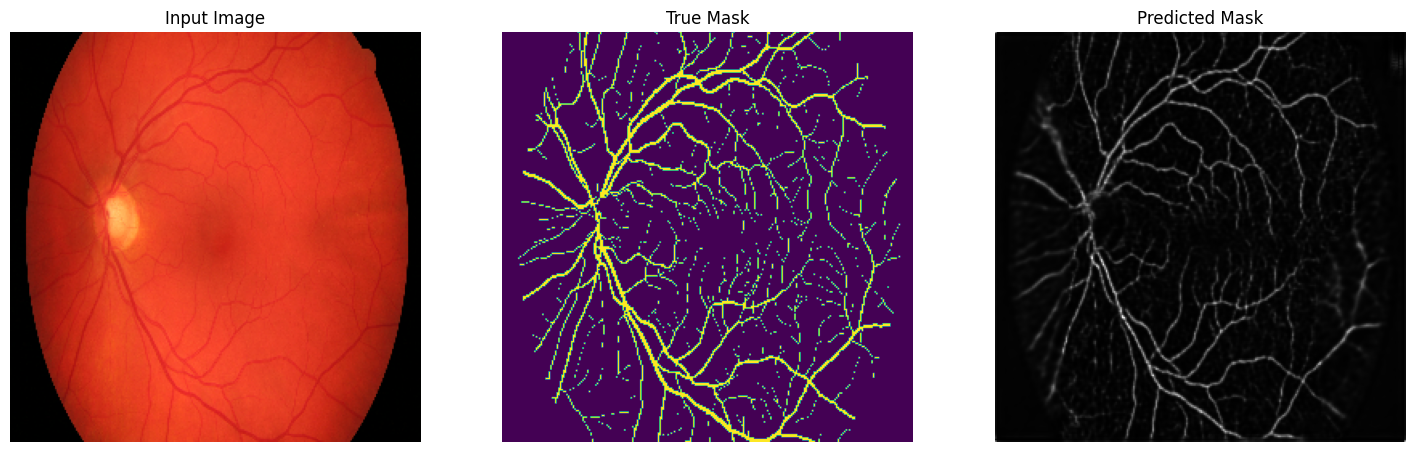

1/1 [==============================] - 0s 38ms/step


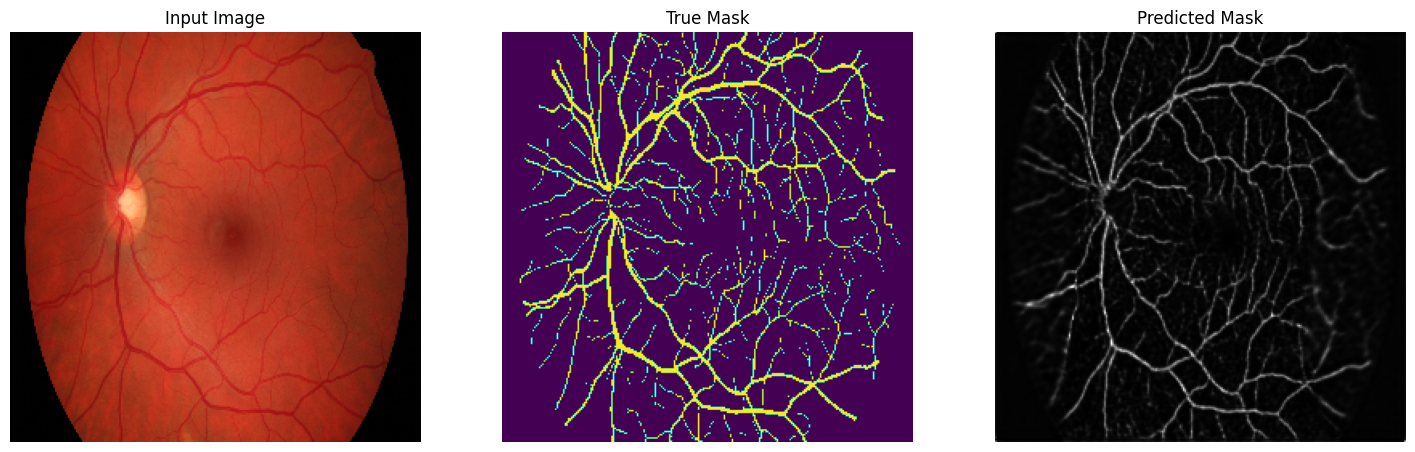

1/1 [==============================] - 0s 43ms/step


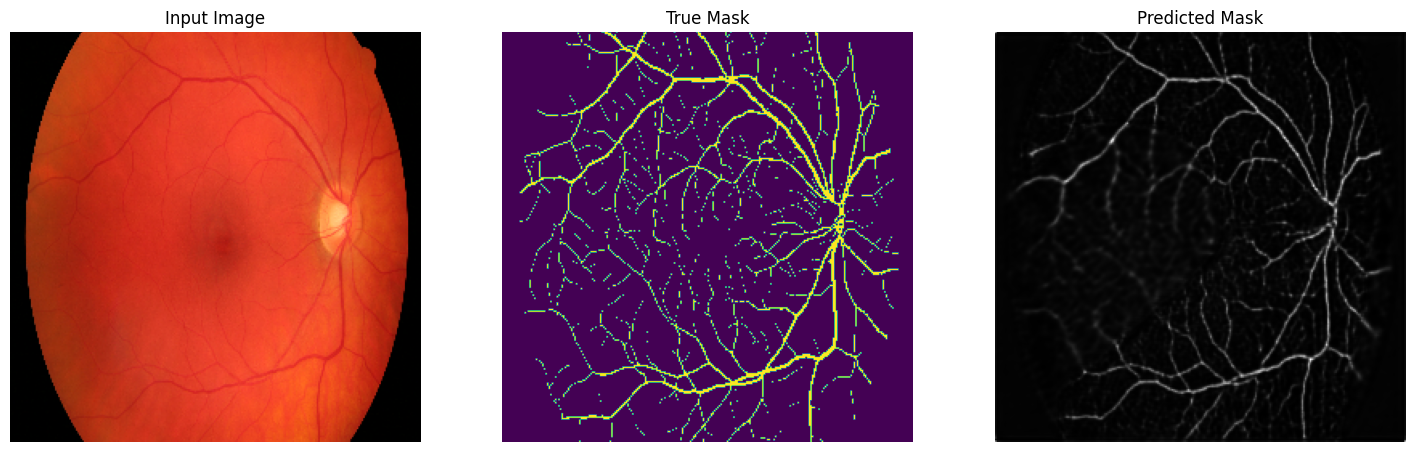

1/1 [==============================] - 0s 45ms/step


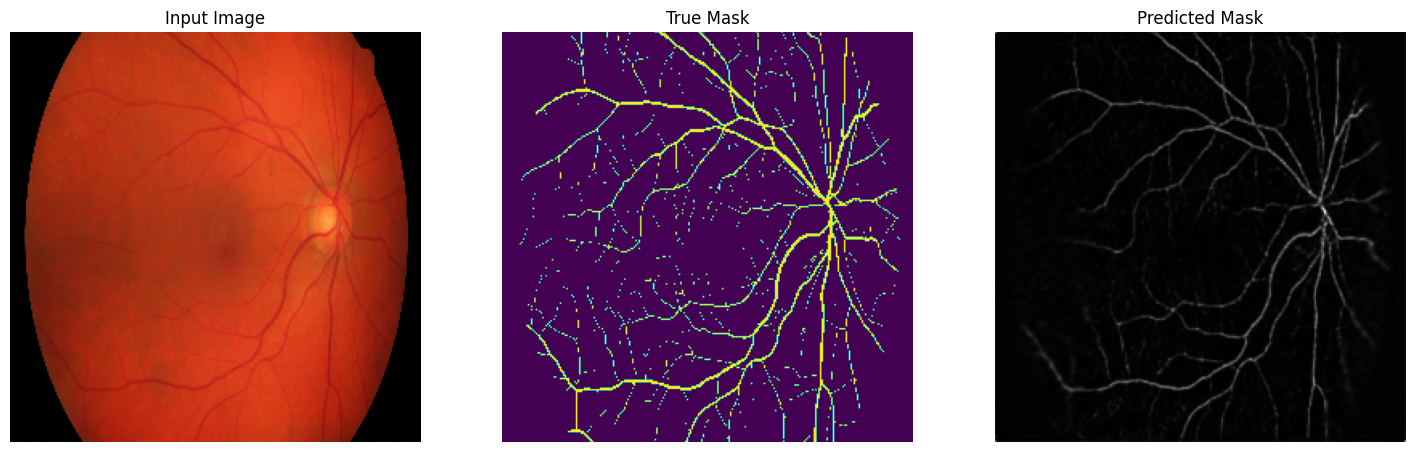

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to visualize the input image, ground truth mask, and predicted mask
def show_predictions(results_list):
    plt.figure(figsize=(18, 6))
    titles = ['Input Image', 'Ground Truth Mask', 'Predicted Mask']
    for idx in range(3):
        plt.subplot(1, 3, idx + 1)
        plt.title(titles[idx])
        plt.imshow(results_list[idx].squeeze(), cmap='gray' if idx == 2 else None)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Path to the pre-trained model
saved_model_path = '/content/segmentation_model_epoch_500.h5'

# Load the trained model from the specified path
trained_model = load_model(saved_model_path)

# Number of samples to display
samples_to_display = min(len(val_images), len(val_masks), 5)

# Generate and visualize predictions for validation samples
for sample_idx in range(samples_to_display):
    sample_image = val_images[sample_idx]
    actual_mask = val_masks[sample_idx]

    # Generate predicted mask using the loaded model
    predicted_mask = trained_model.predict(np.expand_dims(sample_image, axis=0))[0].squeeze()

    # Prepare the list for display
    result_items = [sample_image, actual_mask, predicted_mask]

    # Visualize the input image, true mask, and predicted mask
    show_predictions(result_items)


### Leveraging MobileNet for Image Segmentation
This script highlights the integration of MobileNet as the backbone in a U-Net architecture for image segmentation tasks. By employing MobileNet, known for its efficiency on mobile devices due to depthwise separable convolutions, the model aims to provide a balance between performance and computational cost. The setup involves configuring the segmentation model with ImageNet pre-trained weights to enhance feature extraction capabilities. The model is then compiled with the Adam optimizer and binary cross-entropy loss, making it suitable for binary segmentation tasks.

In [ ]:
import os
import tensorflow as tf
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt

# Configure the environment for segmentation models
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
sm.framework()

# Specify the backbone for the model
BACKBONE = 'mobilenet'
NUM_CLASSES = 1
OUTPUT_ACTIVATION = 'sigmoid'

# Initialize the U-Net model with MobileNet backbone
unet_model = sm.Unet(
    BACKBONE,
    classes=NUM_CLASSES,
    activation=OUTPUT_ACTIVATION,
    encoder_weights='imagenet'
)

# Compile the model with optimizer, loss, and metrics
unet_model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'binary_crossentropy']
)

# Train the model on the prepared dataset
training_history = unet_model.fit(
    x=X_train,
    y=y_train_normalized,
    batch_size=5,
    epochs=500,
    validation_split=0.25,
    verbose=2
)

# Save the trained model to a specified path
model_save_path = '/mnt/data/mobilenet_unet_model.h5'
unet_model.save(model_save_path)
print(f"Model saved at: {model_save_path}")


Epoch 1/500
4/4 - 15s - loss: 0.5815 - accuracy: 0.6642 - binary_crossentropy: 0.5815 - val_loss: 0.1156 - val_accuracy: 0.8782 - val_binary_crossentropy: 0.1156 - 15s/epoch - 4s/step
Epoch 2/500
4/4 - 0s - loss: 0.3890 - accuracy: 0.8899 - binary_crossentropy: 0.3890 - val_loss: 0.0169 - val_accuracy: 0.9220 - val_binary_crossentropy: 0.0169 - 154ms/epoch - 39ms/step
Epoch 3/500
4/4 - 0s - loss: 0.2820 - accuracy: 0.9180 - binary_crossentropy: 0.2820 - val_loss: 0.0093 - val_accuracy: 0.9232 - val_binary_crossentropy: 0.0093 - 151ms/epoch - 38ms/step
Epoch 4/500
4/4 - 0s - loss: 0.2137 - accuracy: 0.9196 - binary_crossentropy: 0.2137 - val_loss: 0.0056 - val_accuracy: 0.9235 - val_binary_crossentropy: 0.0056 - 150ms/epoch - 37ms/step
Epoch 5/500
4/4 - 0s - loss: 0.1666 - accuracy: 0.9195 - binary_crossentropy: 0.1666 - val_loss: 0.0051 - val_accuracy: 0.9236 - val_binary_crossentropy: 0.0051 - 148ms/epoch - 37ms/step
Epoch 6/500
4/4 - 0s - loss: 0.1346 - accuracy: 0.9196 - binary_cros

### Visualizing Model Training Performance
This visualization illustrates the loss metrics for both the training and validation phases across each epoch. By plotting these metrics side by side, we can assess how well the model is learning and generalizing to new data. The blue line represents the training loss, indicating how well the model fits the training data, while the red line shows the validation loss, which provides insight into the model's performance on unseen data.

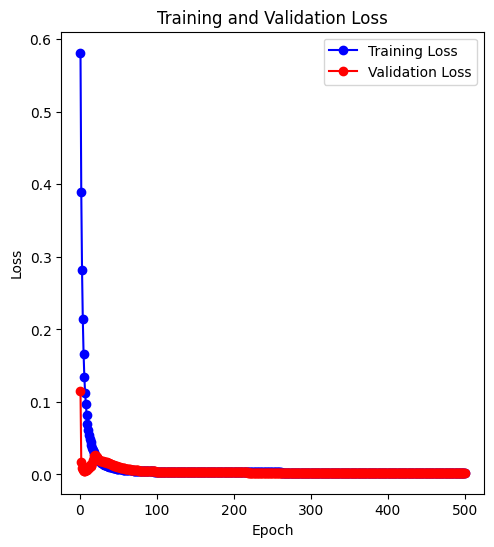

In [ ]:
import matplotlib.pyplot as plt

# Accessing the loss and accuracy data from the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)
# Creating plots for loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()




### Visualizing Predictions from the Trained Model
This script demonstrates how to visualize the outcomes of a trained segmentation model. The function display_images_and_masks is designed to show original images from the dataset alongside their true masks and the masks predicted by the model. Each trio of images includes the original input, the ground truth mask, and the model's prediction, allowing for a direct comparison. This visualization helps in assessing the model's accuracy and effectiveness in capturing the relevant features for mask prediction.

1/1 [==============================] - 1s 585ms/step


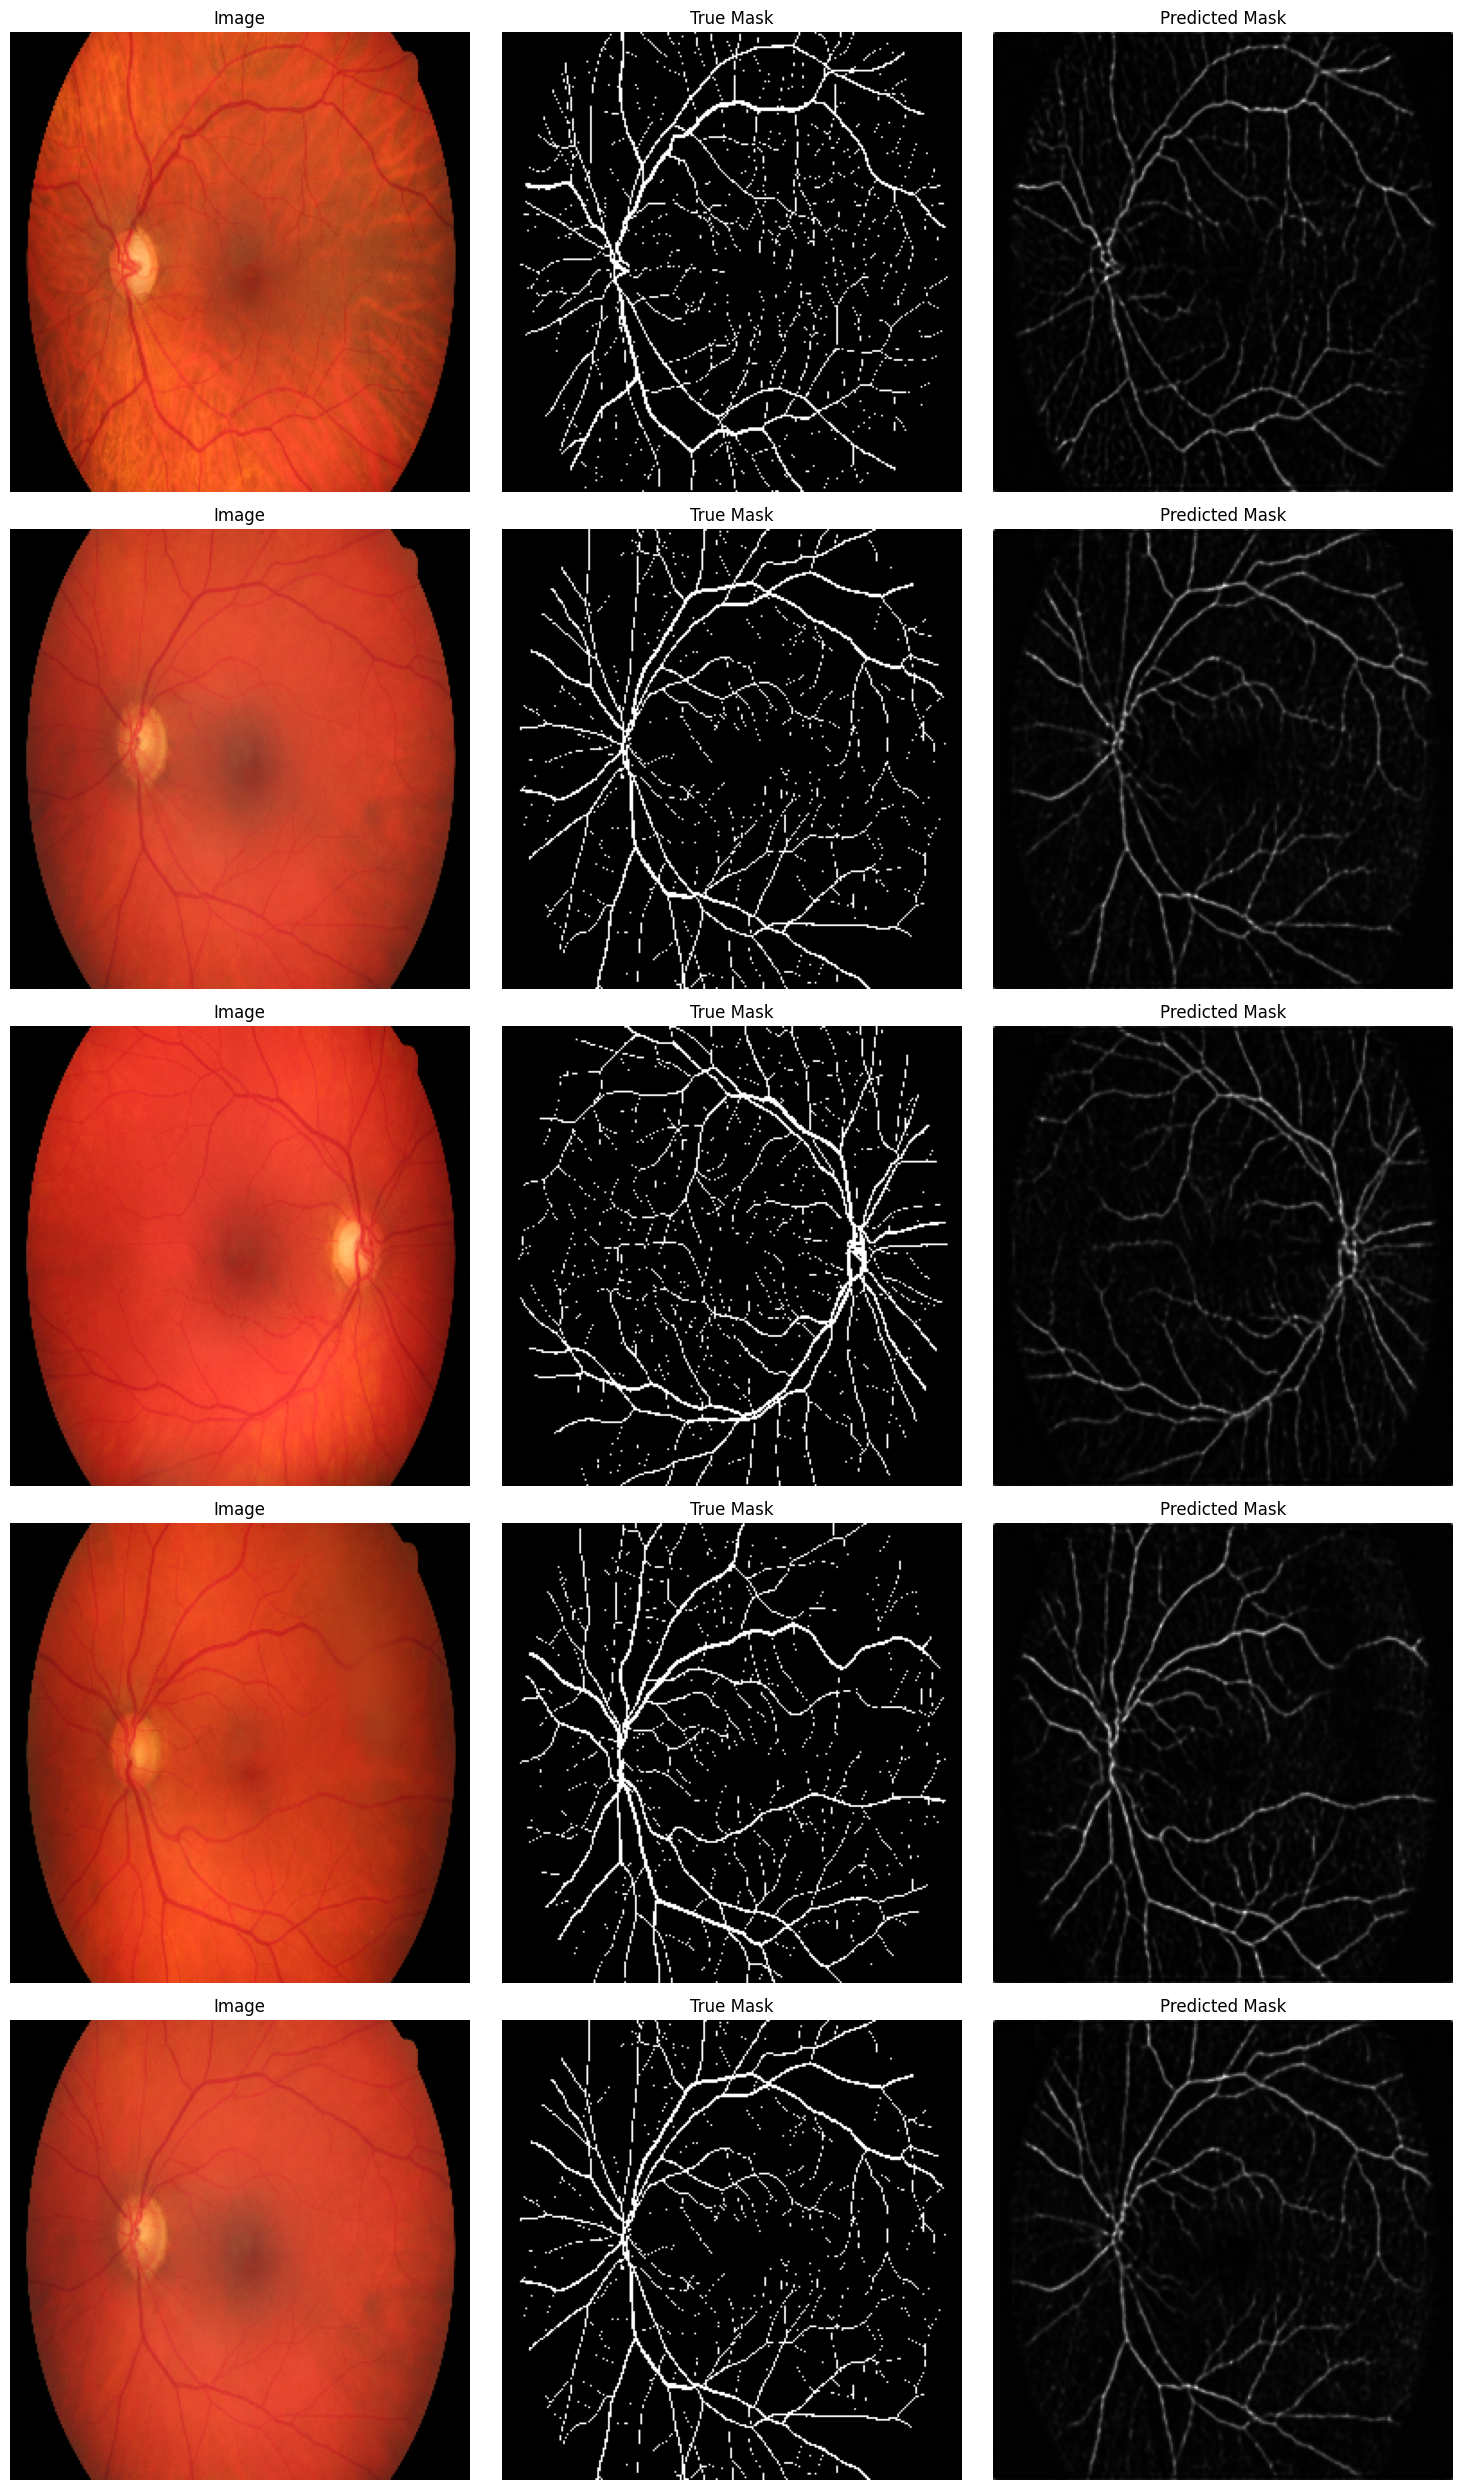

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.models import load_model

# Function to adjust brightness of an image or mask
def modify_brightness(image, factor=1.5):
    return np.clip(image * factor, 0, 1)

# Function to visualize images, ground truth masks, and predicted masks
def visualize_images_with_predictions(images, ground_truth_masks, predicted_masks, samples_to_display=5):
    plt.figure(figsize=(15, 5 * samples_to_display))

    for sample in range(samples_to_display):
        random_index = random.randint(0, len(images) - 1)
        input_image = images[random_index]
        ground_truth = ground_truth_masks[random_index]
        prediction = predicted_masks[random_index]

        # Display the input image
        plt.subplot(samples_to_display, 3, 3 * sample + 1)
        plt.imshow(input_image.squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        # Display the corresponding ground truth mask
        plt.subplot(samples_to_display, 3, 3 * sample + 2)
        plt.imshow(ground_truth.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(samples_to_display, 3, 3 * sample + 3)
        plt.imshow(prediction.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load the trained U-Net model
trained_model = load_model('/content/mobilenet_unet_model.h5')

# Generate predictions for the training dataset
predicted_masks = trained_model.predict(X_train, verbose=1)

# Adjust brightness of the predicted masks (optional for visualization purposes)
enhanced_predictions = np.array([modify_brightness(mask, factor=1.2) for mask in predicted_masks])

# Display a subset of images along with their true masks and predicted masks
visualize_images_with_predictions(X_train, y_train, enhanced_predictions, samples_to_display=5)


### Model Prediction Visualization
This script demonstrates the process of loading a pre-trained image segmentation model and using it to predict the mask for a new image. It begins by defining a function to load and preprocess the image, ensuring it is appropriately sized and normalized for model input. The image and model paths are specified, and the model is loaded from disk. The image is then fed into the model, which predicts the segmentation mask.

1/1 [==============================] - 2s 2s/step


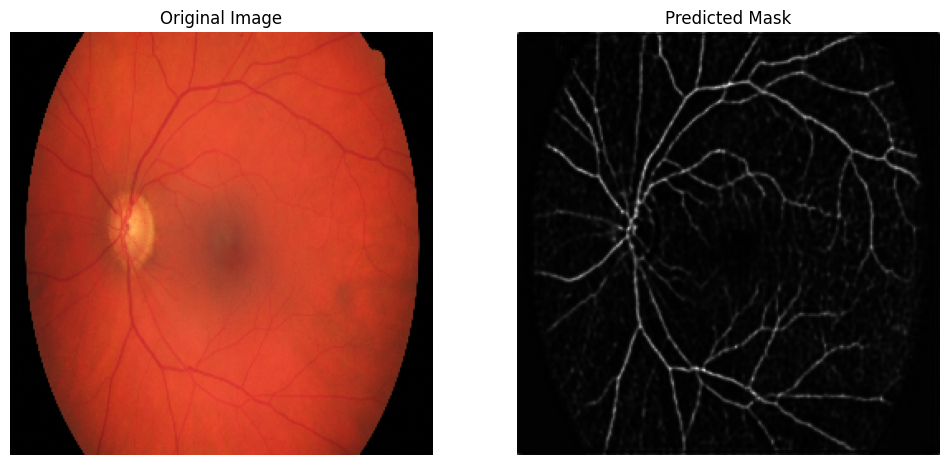

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from PIL import Image

# Function to load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Path to the saved model and image
model_path = '/content/mobilenet_unet_model.h5'
image_path = '/content/Image1.jpg'

# Load the model
model = load_model(model_path)

# Load and preprocess the image
input_image = load_and_preprocess_image(image_path)

# Predict the mask for the input image
predicted_mask = model.predict(input_image)[0].squeeze()

# Display the original image and the predicted mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(input_image), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


### Datasets Link:

Drive Dataset "https://www.kaggle.com/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction"


High-Resolution Fundus (HRF) Image Database "https://www5.cs.fau.de/research/data/fundus-images/"